In [13]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import graphviz

In [15]:
import graphviz

In [16]:
bank_df = pd.read_csv("/Users/superman/Desktop/Education/MBA/Semester-V/BUSI 650/UniversalBank1.csv")
 


In [17]:
# data preprocess
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
bank_df.head(2)

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0


In [18]:
# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Ugrad', 2: 'Grad', 3: 'Advncd-Prof'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

C:\Users\Superman\AppData\Local\Temp\ipykernel_17516\503402086.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  bank_df.Education.cat.rename_categories(new_categories, inplace=True)


In [19]:
bank_df.head(2)

,ID,Age,Experience,Income,ZIP_Code,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_Grad,Education_Advncd-Prof
0,1,25,1,49,91107,4,1.6,0,0,1,0,0,0,0,0
1,2,45,19,34,90089,3,1.5,0,0,1,0,0,0,0,0


In [20]:
# split the train and validation data
x = bank_df.drop(['Personal_Loan', 'ZIP_Code', 'ID'], axis='columns')
y = bank_df['Personal_Loan']
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = .2, random_state = 1)

In [21]:
train_x.shape,train_y.shape

((4000, 12), (4000,))

In [22]:
train_y.head()

1233    0
1056    0
1686    0
187     1
3840    0
Name: Personal_Loan, dtype: int64

In [23]:
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_x, train_y)

plotDecisionTree(fullClassTree, feature_names=train_x.columns)

InvocationException: GraphViz's executables not found

In [12]:
classificationSummary(train_y, fullClassTree.predict(train_x))
classificationSummary(val_y, fullClassTree.predict(val_x))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 3620    0
     1    0  380
Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual   0   1
     0 893   7
     1  14  86


In [13]:
treeClassifier = DecisionTreeClassifier(random_state=1)

scores = cross_val_score(treeClassifier, train_x, train_y, cv=5)
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

Accuracy scores of each fold:  ['0.981', '0.981', '0.979', '0.988', '0.989']


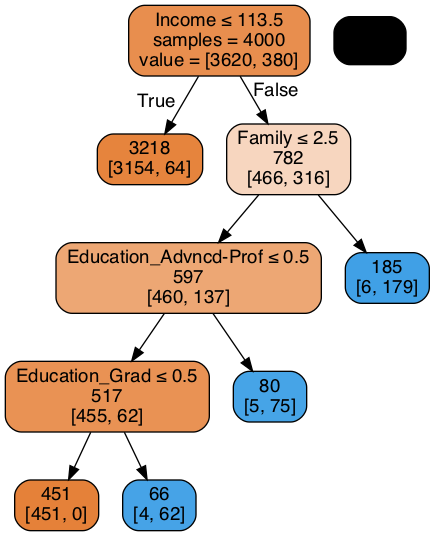

In [14]:
smallClassTree = DecisionTreeClassifier(max_depth=30, min_samples_split=20,
                        min_impurity_decrease=0.01, random_state=1)
smallClassTree.fit(train_x, train_y)

plotDecisionTree(smallClassTree, feature_names=train_x.columns)

In [15]:
classificationSummary(train_y, smallClassTree.predict(train_x))
classificationSummary(val_y, smallClassTree.predict(val_x))

Confusion Matrix (Accuracy 0.9802)

       Prediction
Actual    0    1
     0 3605   15
     1   64  316
Confusion Matrix (Accuracy 0.9780)

       Prediction
Actual   0   1
     0 898   2
     1  20  80


code for using GridSearchCV to fine tune method parameters

In [16]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, 
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
gridSearch.fit(train_x, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)),  # 14 values 
    'min_samples_split': list(range(10, 22)), # 11 values
    'min_impurity_decrease': [0.0009, 0.001, 0.0011], # 3 values
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, 
                          n_jobs=-1)
gridSearch.fit(train_x, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.985
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved score:  0.98325
Improved parameters:  {'max_depth': 7, 'min_impurity_decrease': 0.0009, 'min_samples_split': 19}


code for plotting and evaluating performance of fine-tuned classification tree


In [17]:
# fine-tuned tree: training
classificationSummary(train_y, bestClassTree.predict(train_x))

Confusion Matrix (Accuracy 0.9895)

       Prediction
Actual    0    1
     0 3607   13
     1   29  351


In [18]:
# fine-tuned tree: validation
classificationSummary(val_y, bestClassTree.predict(val_x)) 

Confusion Matrix (Accuracy 0.9800)

       Prediction
Actual   0   1
     0 894   6
     1  14  86


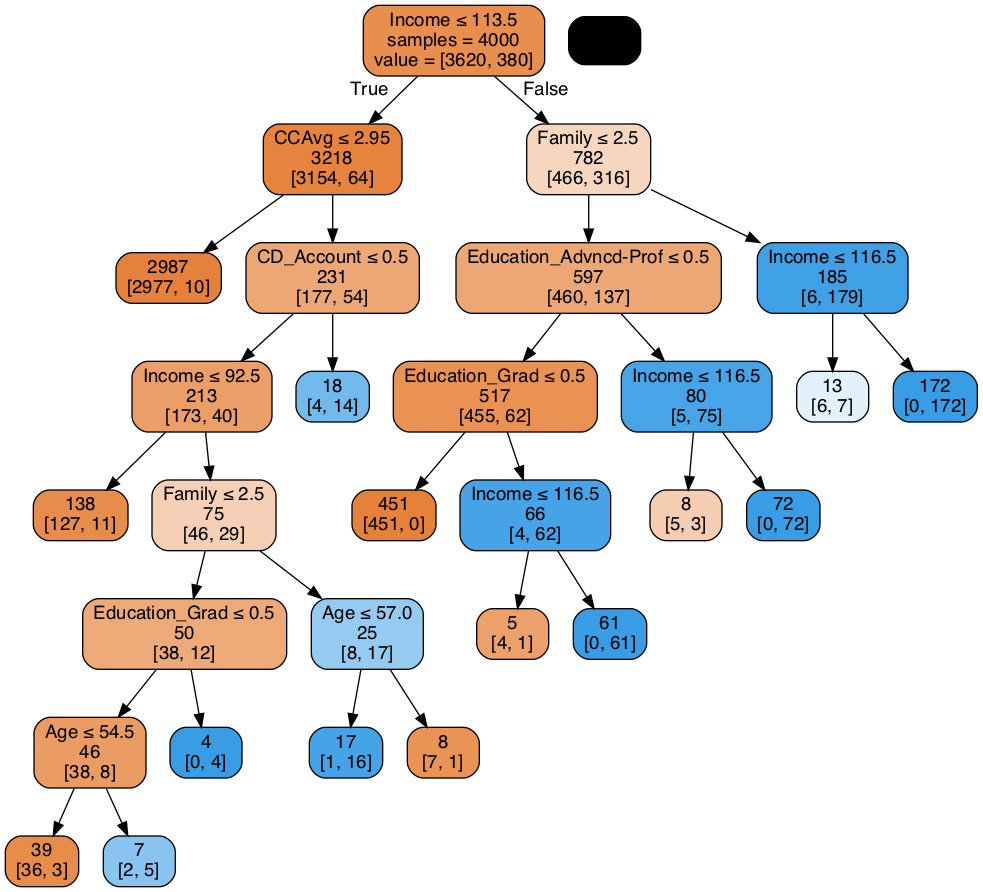

In [19]:
plotDecisionTree(bestClassTree, feature_names=train_x.columns)